<a target="_blank" href="https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/04_cnn/04_seminar_cnn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Свёрточные сети (CNN)


<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/toc_meme.png" width=400 />

## Recap: регуляризация

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

### Dropout

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
do = nn.Dropout(p=0.5)
do

True


Dropout(p=0.5, inplace=False)

In [ ]:
t = torch.arange(0, 15, dtype=torch.float32).reshape(3, 5)
t

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])

In [ ]:
do.train()
print("training", do.training)
do(t)

tensor([[ 0.,  0.,  0.,  6.,  0.],
        [ 0., 12.,  0.,  0., 18.],
        [ 0.,  0., 24., 26., 28.]])

In [ ]:
do.eval()
print("training", do.training)
do(t)

False


### Optimizers

1. **SGD** — самый простой вариант оптимизатора, не хранит статистики по параметрам.
2. **Adam** — хранит сразу 2 статистики на каждый параметр нейросети (первый и второй момент). Благодаря этому быстрее сходится, но занимает доп. место на видеокарте.

In [ ]:
from torchvision.models import resnet18
import torch.optim as optim
import torch

resnet = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


In [ ]:
sum(p.numel() for p in resnet.parameters() if p.requires_grad) * 4 / 1024/1024

44.591949462890625

In [ ]:
resnet = resnet.to('cuda')

In [ ]:
!nvidia-smi

Sat Feb 10 14:04:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              30W /  70W |    167MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Adam

In [ ]:
adam = optim.Adam(resnet.parameters(), lr=3e-4)

out = resnet.forward(torch.rand(1, 3, 224, 224).to('cuda'))
loss = out.mean()
loss.backward()

adam.step()

In [ ]:
!nvidia-smi

Sat Feb 10 14:04:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              30W /  70W |    423MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### SGD

Потребляет меньше видеопамяти (ноль), т.к. не хранит моменты по градиентам.


In [ ]:
sgd = optim.SGD(resnet.parameters(), lr=3e-4)

out = resnet.forward(torch.rand(1, 3, 224, 224).to('cuda'))
loss = out.mean()
loss.backward()

sgd.step()

In [ ]:
!nvidia-smi

Sat Feb 10 14:05:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              30W /  70W |    459MiB / 15360MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### ❓ **Вопрос**: Почему потребляется сильно больше видеопамяти, чем занимает модель и состояние оптимизатора? На что ещё расходуется видеопамять?

<!-- градиенты, активации - кэши не освобождаются, потому что само выделение памяти - это долгий процесс -->

---

### BatchNorm2d

[BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

**Почему работает? (из слайдов лекции)**

- Internal covariate shift → на разных слоях значения активаций более стабильны.
- Делает более гладкой поверхность функции потерь → оптимизировать такую функцию проще.
- Регуляризация: на каждом батче статистики разные → в процесс обучения такой способ подсчёта статистик вносит шум.



In [ ]:
affine_bn = nn.BatchNorm2d(3, affine=True)
affine_bn.eval()
affine_bn.train()

affine_bn

BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
affine_bn.train()
affine_bn.training

True

In [ ]:
affine_bn.eval()
affine_bn.training

False

In [ ]:
list(affine_bn.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True), Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

In [ ]:
not_affine_bn = nn.BatchNorm2d(3, affine=False )
not_affine_bn

BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)

In [ ]:
list(not_affine_bn.parameters())

[]

### Что происходит под капотом?

In [ ]:
# очень грубо!
# важно, что средние значения и дисперсия считаются для каждого слоя отдельно
# в этом примере это не так
def forward(self, data: torch.Tensor, eps=1e-5):
    data = (data - data.mean()) / data.std()
    # data = data * self.affine_std + self.affine_mean
    return data

In [ ]:
t = torch.arange(0, 45, dtype=torch.float32).view(1, 3, 3, 5)
t.shape

torch.Size([1, 3, 3, 5])

In [ ]:
t_bn = not_affine_bn(t)
t_bn.shape

torch.Size([1, 3, 3, 5])

In [ ]:
t_bn

tensor([[[[-1.6202e+00, -1.3887e+00, -1.1573e+00, -9.2582e-01, -6.9436e-01],
          [-4.6291e-01, -2.3145e-01,  0.0000e+00,  2.3145e-01,  4.6291e-01],
          [ 6.9436e-01,  9.2582e-01,  1.1573e+00,  1.3887e+00,  1.6202e+00]],

         [[-1.6202e+00, -1.3887e+00, -1.1573e+00, -9.2582e-01, -6.9437e-01],
          [-4.6291e-01, -2.3146e-01, -2.3842e-07,  2.3145e-01,  4.6291e-01],
          [ 6.9436e-01,  9.2582e-01,  1.1573e+00,  1.3887e+00,  1.6202e+00]],

         [[-1.6202e+00, -1.3887e+00, -1.1573e+00, -9.2582e-01, -6.9437e-01],
          [-4.6291e-01, -2.3146e-01, -3.5763e-07,  2.3145e-01,  4.6291e-01],
          [ 6.9436e-01,  9.2582e-01,  1.1573e+00,  1.3887e+00,  1.6202e+00]]]])

In [ ]:
(t - t.mean()) / t.std()

tensor([[[[-1.6751, -1.5989, -1.5228, -1.4466, -1.3705],
          [-1.2944, -1.2182, -1.1421, -1.0659, -0.9898],
          [-0.9137, -0.8375, -0.7614, -0.6852, -0.6091]],

         [[-0.5330, -0.4568, -0.3807, -0.3046, -0.2284],
          [-0.1523, -0.0761,  0.0000,  0.0761,  0.1523],
          [ 0.2284,  0.3046,  0.3807,  0.4568,  0.5330]],

         [[ 0.6091,  0.6852,  0.7614,  0.8375,  0.9137],
          [ 0.9898,  1.0659,  1.1421,  1.2182,  1.2944],
          [ 1.3705,  1.4466,  1.5228,  1.5989,  1.6751]]]])

In [ ]:
# еще есть параметр track_running_stats, про него можно подробнее посмотреть в домашке
bn_track_running_stats = nn.BatchNorm2d(3, affine=True, track_running_stats=True)

# means by channel, vars by channel, count steps
list(bn_track_running_stats.buffers())

[tensor([0., 0., 0.]), tensor([1., 1., 1.]), tensor(0)]

## Работа с изображениями

#### ❓ **Вопрос**: Что хранится в значении пикселя? (число от 0 до 255)

#### ❓ **Вопрос**: Что если все цвета 255?

#### ❓ **Вопрос**: Что если все цвета 0?

#### ❓ **Вопрос**: Что если `red = 255`, а `green = blue = 0`?

#### ❓ **Вопрос**: Что если все каналы равны друг другу?

In [ ]:
[ 1, 64, 64 ] # черно-белая

[ 3, 64, 64 ] # цветная картинка

[3, 64, 64]

In [ ]:
!wget https://i.imgflip.com/62ixgw.jpg

--2025-02-10 16:44:22--  https://i.imgflip.com/62ixgw.jpg
Resolving i.imgflip.com (i.imgflip.com)... 104.16.40.101, 104.16.71.101
Connecting to i.imgflip.com (i.imgflip.com)|104.16.40.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69445 (68K) [image/jpeg]
Saving to: ‘62ixgw.jpg’

62ixgw.jpg          100%[===================>]  67.82K  --.-KB/s    in 0.008s  

2025-02-10 16:44:22 (8.08 MB/s) - ‘62ixgw.jpg’ saved [69445/69445]



### RGB-каналы

У изображений обычно 3 канала. Мы будем работать с RGB-каналами.

---

Значение каждого пикселя [0..255] — это его яркость.

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_bgr = cv2.imread("./62ixgw.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_rgb.shape

(433, 577, 3)

In [ ]:
img_rgb[:3, :3, :]

array([[[155, 181, 204],
        [157, 183, 206],
        [160, 186, 209]],

       [[145, 171, 194],
        [151, 177, 200],
        [158, 184, 207]],

       [[136, 162, 185],
        [140, 166, 189],
        [145, 171, 194]]], dtype=uint8)

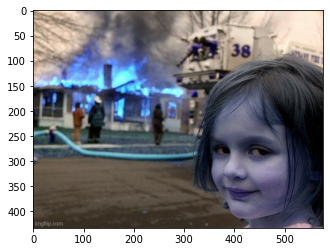

In [ ]:
plt.imshow(img_bgr)

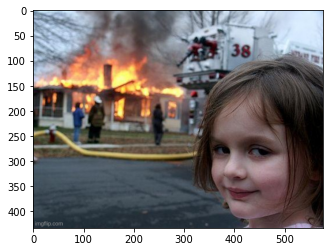

In [ ]:
plt.imshow(img_rgb)

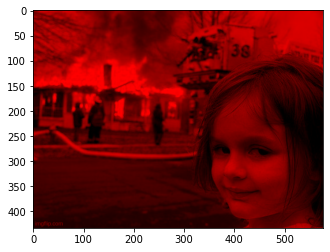

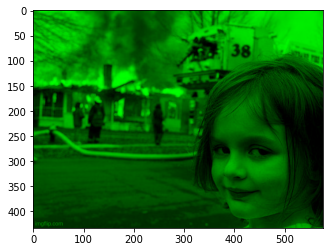

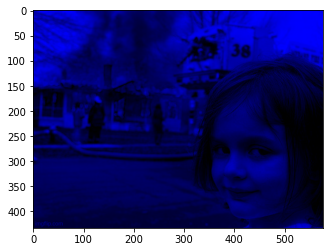

In [ ]:
for i in range(3):
    plt.figure(i)
    img_copy = img_rgb.copy()
    img_copy[:, :, (i + 1) % 3] = 0
    img_copy[:, :, (i + 2) % 3] = 0
    plt.imshow(img_copy)

## Свертки

Документация: [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

* **kernel_size** --- размер ядра свертки (так ядро иногда называют фильтром). На гифке размер ядра 3 на 3. Можно сделать несимметричную свертку (например, 1 на 10), но на практике используют симметричные
* **padding** --- отступ, ширина "рамочки", котрая будет дорисовываться вокруг нашего изображения
* **stride** --- размер шага ядра


**Важно**: ядро -- это серый квадратик (3x3), который бегает по синему  квадратику. Зеленый квадратик -- это результат работы свертки.




<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/conv2d.gif" width=400 />



### Визуализация свертки

Забегая вперед, это визуализация: `nn.Conv2d(1, 1, kernel_size=3, stride=2, padding=1)`

Результаты свертки каждого скользящего окна складываются


### Как свертки работают для цветного изображения?

Го в гифку https://cs231n.github.io/convolutional-networks/

> The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias

### Попробуем применить свертку к изображению

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```


In [ ]:
!wget https://www.hse.ru/data/2021/08/25/1414838109/3HSE-8086_Preview.jpeg -O hse.jpeg

--2023-02-06 13:42:33--  https://www.hse.ru/data/2021/08/25/1414838109/3HSE-8086_Preview.jpeg
Resolving www.hse.ru (www.hse.ru)... 178.248.234.104
Connecting to www.hse.ru (www.hse.ru)|178.248.234.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59741 (58K) [image/jpeg]
Saving to: ‘hse.jpeg’

hse.jpeg            100%[===================>]  58.34K  --.-KB/s    in 0.1s    

2023-02-06 13:42:35 (457 KB/s) - ‘hse.jpeg’ saved [59741/59741]



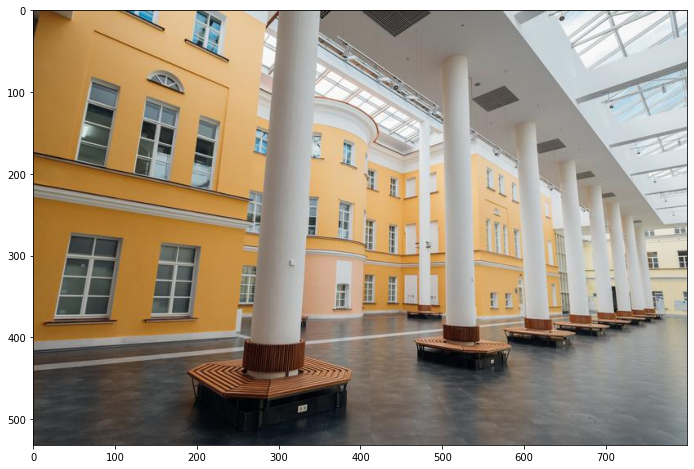

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./hse.jpeg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

                                   #                       out, in, kernel_width, kernel_height
kernel = kernel.repeat(3, 3, 1, 1) # result kernel size is [ 3, 3,  3,            3 ]
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

In [ ]:
result.shape

torch.Size([3, 532, 800])

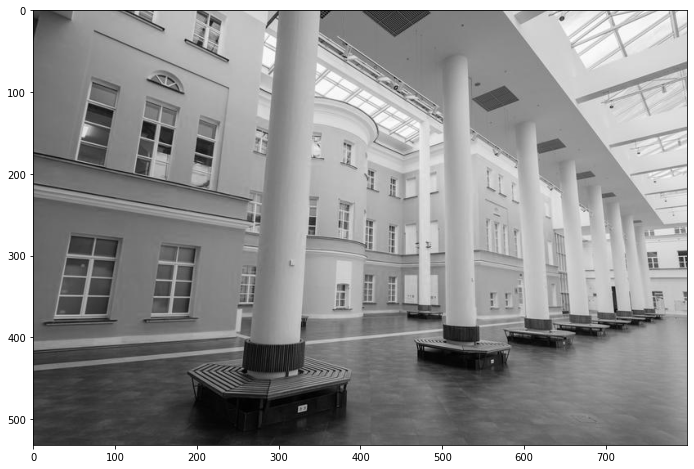

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np[:, :, :])
plt.show()

#### ❓ **Вопрос**: Почему изображение потеряло цвет?

Для каждого пикселя каждого слоя наша свертка берет усредненный цвет по всем слоям.

### Свертки в PyTorch

### Тренировочный цикл (FashionMNIST)

Копипаста с предыдущего семинара — ничего нового.

In [ ]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

# ничего нового, копипаста с предыдущего сема
class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255

        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

In [ ]:
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

class Trainer:
    def __init__(self, model: nn.Module, optimizer,
                 train_dataset: Dataset, val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/', batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)


    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k + "/train", v, global_step=self.global_step)
                self.global_step += 1

            with torch.no_grad():
                model.eval()
                val_losses = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    for k, v in details.items():
                        self.log_writer.add_scalar(k + '/validation', v, global_step=self.global_step)
                    val_losses.append(loss.item())

                val_loss = np.mean(val_losses)

                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss


### CNNModel

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(
            # input ~ [ bs, 1, w, h ]

            # параметры ядра и паддинг специально стараемся подбирать такими,
            # чтобы не изменялись пространственные размерности картинки
            nn.Conv2d(1, 8, kernel_size=3, padding=1), # [ bs, 8, w, h ]
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1), # [ bs, 4, w, h ]

            nn.Flatten(1), # [ bs, 4 * w * h ]
            nn.Linear(4 * 28 * 28, 10), # [ bs, 10 ]
        )

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample'] # [ bs, 1, w, h ]
        y = batch['label']
        x = x.unsqueeze(1)
        # print(x.shape)
        logits = self.inner(x) # [ bs, 10 ]
        assert logits.size() == torch.Size([ x.size(0), 10 ]), f"logits size is wrong: {logits.size}"

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

# проверяйте работоспособность сразу
cnn_model = CNNModel()
cnn_opt = optim.SGD(cnn_model.parameters(), lr=1e-2)
cnn_trainset = FMNISTImageSet(train=True)
cnn_valset = FMNISTImageSet(train=False)

cnn_trainer = Trainer(cnn_model, cnn_opt, cnn_trainset, cnn_valset, batch_size=128)

In [ ]:
cnn_trainer.train(3)

100%|██████████| 79/79 [00:01<00:00, 61.00it/s]


### Сравнение MLP vs CNN

In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample']
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

model = MLPModel()

In [ ]:
sum( p.numel() for p in model.parameters() if p.requires_grad)

79510

In [ ]:
sum( p.numel() for p in cnn_model.parameters() if p.requires_grad)

23829

## Pooling и рецептивное поле

### Pooling

> It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.

> https://cs231n.github.io/convolutional-networks/#pool

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/pooling.png" width=400 />

In [ ]:
!wget https://i.imgflip.com/658r4d.jpg

--2023-02-06 13:53:26--  https://i.imgflip.com/658r4d.jpg
Resolving i.imgflip.com (i.imgflip.com)... 104.18.64.15, 104.18.255.14
Connecting to i.imgflip.com (i.imgflip.com)|104.18.64.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39502 (39K) [image/jpeg]
Saving to: ‘658r4d.jpg’

658r4d.jpg          100%[===================>]  38.58K  --.-KB/s    in 0.002s  

2023-02-06 13:53:26 (17.7 MB/s) - ‘658r4d.jpg’ saved [39502/39502]



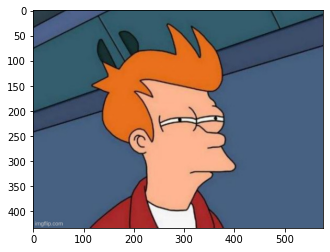

In [ ]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("658r4d.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [ ]:
maxpool = nn.MaxPool2d(7)
maxpool

MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)

**Обучаемые параметры?** Нет

In [ ]:
list(maxpool.parameters())

[]

### Применение пулинга к изображению

In [ ]:
image_t = torch.tensor(image, dtype=float)
image_t.shape

torch.Size([433, 577, 3])

In [ ]:
polled_image_t = maxpool(image_t.unsqueeze(0).transpose(3, 1)).transpose(3, 1)[0, ...]
polled_image_t.shape

torch.Size([61, 82, 3])

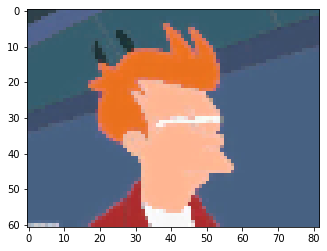

In [ ]:
plt.imshow(polled_image_t.numpy().astype(int))

### Global Pooling

[AdaptiveAvgPool2d](https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)




In [ ]:
# [ bs, 3, 225, 224 ]

# [ bs, 512, 17, 17 ]
# Linear(512 * 16 * 16, 10)

In [ ]:
# разные пространственные размерности!
# [ bs, 512, 8, 8 ] + flatten(1)    = [ bs, 512, 8, 8 ]
# [ bs, 512, 17, 17 ]  + flatten(1) = [ bs, 512 * 17 * 17 ]

In [ ]:
# AvgPooling
# [ bs, 512, 17, 17 ] ->  [ bs, 512, 1, 1 ] -> [ bs, 512 * 1 * 1 ]
# Linear(512, 10)

In [ ]:
avg_pool = nn.AdaptiveAvgPool2d((2, 2))
avg_pool

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
list(avg_pool.parameters())

[]

In [ ]:
bs = 3
filters_cnt = 128
dimx = 64
dimy = 64

filters = torch.rand((bs, filters_cnt, dimx, dimy))

avg_pool(filters).shape

torch.Size([3, 128, 1, 1])

### Рецептивное поле

[Источник картинки](https://discuss.pytorch.org/t/dynamic-structure-of-cnn/45870/2)

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/receptive_field.png" width=400 />

## TorchVision Models


### Residual Block, ResNet

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/skip_connection.png" width=400 />

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        """
        in_dim --- размерность слоев на входе (используется в nn.Conv2d)
        hidden_dim --- скрытая размерность слоев (используется в nn.Conv2d)
        """

        self.model = nn.Sequential(
            nn.Linear( 3, 3, kernel_size=3),
            nn.ReLU(),
            nn.Linear( 3, 3, kernel_size=3),
        )

        self.activation = nn.ReLU()

        return

    def forward(self, x):

        f_x = self.activation((self.model(x)))

        return f_x + x


In [ ]:
from torchvision.models import resnet18
import torch.optim as optim
import torch

resnet = resnet18(pretrained=True) # pretrained=True
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Как применить существующую модель к моей задаче?

**Fine tuning**

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

resnet = resnet18(pretrained=True)
prev_in_features = resnet.fc.in_features
resnet.fc = nn.Linear(prev_in_features, 10)

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Что дальше?

Стоит постепенно размораживать веса модели. Если начать учить end2end, могут испортиться ядра сверток, так как от нового слоя потекут плохие градиенты, потому что он инициализирован рандомно.




In [ ]:
# замораживаем веса для backbone'а сети
for p in resnet.parameters():
    p.requires_grad = False

# размораживаем наш классификатор
for p in resnet.fc.parameters():
    p.requires_grad = True

# for p in resnet.layer4.parameters():
#     p.requires_grad = True


In [ ]:
sum(p.numel() for p in resnet.parameters() if p.requires_grad)

5130

## Мега Блиц!

#### ❓ **Вопрос**: Зачем нужен параметр `affine` в BatchNorm?

<!-- BN нромализует входной батч. Но может оказаться, что нейросети нужно какое-то смещение или какой-то std. Поэтому в этом слое создаются обучаемые параметры, которые так же вносят вклад в градиент. Чтобы если что, сеть могла выучить необходимое смещение, ско -->


#### ❓ **Вопрос**: В каком месте нужно располагать слой `BatchNorm`?

```python
nn.BatchNorm2d() -> nn.Conv2d(...) -> nn.ReLU()
```

```python
nn.Conv2d(...) -> nn.BatchNorm2d() -> nn.ReLU()
```

```python
nn.Conv2d(...) -> nn.ReLU() -> nn.BatchNorm2d()
```

<!-- Первый и третий вариант эквивалентны, если рассматривать этот паттерн в глобокой сети.

А и первый и втроой (или третий и второй) варианты оба имеют место быть.
 -->



#### ❓ **Вопрос**: Можно ли использовать после слоя `Dropout` `BatchNorm`?

<!-- Скорее всего, полностью процесс обучения это не сломает. Но более логично было бы сначала применить BatchNorm, потом Dropout -->

#### ❓ **Вопрос**: Зачем нужен `transform=` в классе датасета? Когда его нужно применять?

<!---
    В этот параметр передается функция для предобработки изображения. Эта функция обычно преобразует PIL Image объект (если вы прочитали изображение с помощью cv2) или numpy.array в тензор, нормализует значения пикселей (делит на 255). Самый простой вариант трансформа --- это [ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor)


    Еще с помощью этого метода можно сделать аугментацию изображения:

    * [Resize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize) --- отмасштабировать изображение
    * [RandomHorizontalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip) --- перевернуть
    * [RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation) --- повернуть

    С помощью аугментаций мы расширяем обучающую выборку при этом не прибегая к ручному сбору данных. Это позволяет обучить более стабильную сеть, часто повысить качество сети.

--->

#### ❓ **Вопрос**: Какие основные параметры у свертки?

<!--
Обучаемые параметры
* in/out + kernel_size # одна матрица размерности `[in, out, kernel_size[0], kernel_size[1]]`

Параметры, влияющие на процесс вычисления свертки
* padding
* stride -->


<!-- sum(map(lambda x: x.numel(), nn.Conv2d(3, 3, kernel_size=3).parameters())) -->


#### ❓ **Вопрос**: Сколько параметров будет у свертки `nn.Conv2d(3, 3, kernel_size=3)`?
<!--

nn.Conv2d(3, 3, kernel_size=3)

[3, 3, 3, 3]

kernel_size=3 ~ kernel_size=(3, 3)

```python

вроде 84 (+bias)

``` -->


#### ❓ **Вопрос**: Для того, чтобы свертка с ядром 3×3 не изменяла пространственную размерность изображения при `stride=1`, мы используем `padding=1`. Какое значение `padding` нужно использовать для ядра 5×5 и `stride=1`?

<!-- `padding=2` -->

#### ❓ **Вопрос**: Как вы думаете, какие ядра выучивают реальные нейросетки на настоящих картинках?

<!-- Вообще говоря, принято считать, что фильтры выучиват текстуры. И используя это можно обмануть нейросеетвой классификатор, например, если показать ему рыбу с текстурой чешуи как кожа коровы, то классификатор, скорее всего будет считать это коровой.

Сами ядра можно визуализировать

https://deeplizard.com/learn/video/cNBBNAxC8l4

<img src="https://deeplizard.com/assets/jpg/c50ac9ac.jpg" width=400> -->

#### ❓ **Вопрос**: В начале сема есть 6 сверток, пронумерованные буквами. Сопоставьте ядра действию, которое делает это ядро:

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ
<!--
```
A 3
Б 4
В 5
Г 6
Д 1
Е 2
``` -->

#### ❓ **Вопрос**: Какой размерности свертка и какие у неё параметры в cs231?

гифку https://cs231n.github.io/convolutional-networks/

> The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias

```
Conv2d(?, ?, kernel_size=?, padding=?, stride?)
```

<!-- Conv2d(3, 2, kernel_size=3, padding=1, stride=2) -->


#### ❓ **Вопрос**: После применения свертки к изображению мы получили 10 фильтров. За счёт чего мы получаем разные значения в этих фильтрах?


<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/04_cnn/static/quiz_conv_values.png" width=400 />


#### ❓ **Вопрос**: Какое рецептивное поле у одной ячейки выходного тензора сверточной сети, состоящей из двух подряд идущих сверток 3×3 (`stride=1`)?

```
nn.Sequential(
    nn.Conv2d(in, out_1,    kernel_size=3),
    # ...
    nn.Conv2d(out_1, out_2, kernel_size=3),
)
```

Другими словами: какое количество пикселей вложили свои значения в один "пиксель" итогового фильтра (feature-map'ки это одно и то же)?


<!--
    Ответ 5*5=25 . Рецептивное поле одного пикселя первого фильтра 3x3.
    Если взять квадратик 3x3 этого фильтра, то это будет соответствовать как раз одному "пикселю" второго фильтра. И квадратику 5x5 исходного изображения
-->

#### ❓ **Вопрос**: Чем Pooling отличается от Adaptive Global Pooling?

<!--

Global Polling действует по всей пространственной размерности картинки. Обычно выходом Global Polling является тензор [ bs, channels, 1, 1 ]

Polling же просто уменьшает пространственную размерность изображения/предыдущего фильтра. Это позволяет увеличить рецептивное поле последующих нейронов

-->

#### ❓ **Вопрос**: Зачем мы хотим увеличить рецептивное поле на более глубоких слоях?

<!--

Если решаем задачу классфикации, то последним слоем идет Linear. Этот слой применяется к последней фича-мапе.

Linear ничего не умеет знать про структуру картинки, но никак не учитывает расположение пикселей, их "соседство". Но сами значениях последнего фильтра могут содержать такую информацию и потенциально чем больше рецептивное поле, тем больше информации мы можем сохранить в последнем фильтре

-->

#### ❓ **Вопрос**: Как определяется порядок слоёв и размерности скрытых состояний в `MLP` или количество фильтров в `CNN`?

#### ❓ **Вопрос**: Что делает `.detach`?

#### ❓ **Вопрос**: Что делает `.to('cuda')`?

#### ❓ **Вопрос**: Что будет в результате работы этого сниппета?

```python
ones_cuda = torch.ones([ 10 ]).to('cuda')
torch.zeros([ 10 ]) + ones_cuda
```

Будет ли это быстрее, чем если убрать `.to('cuda')`

```python
ones_cuda = torch.ones([ 10 ])
torch.zeros([ 10 ]) + ones_cuda
```



## Домашки

- pytorch-basics
- batchnorm
